# Probability of Default Model using ValidMind

- Step 1: Connect Notebook to ValidMind Project
- Step 2: Import Raw Data
- Step 3: Data Description
- Step 4: Data Preparation
- Step 5: Data Description on Preprocessed Data 
- Step 6: Univariate Analysis
- Step 7: Multivariate Analysis
- Step 8: Model Training 

## Step 1: Connect Notebook to ValidMind Project

#### Import Libraries

In [1]:
# Load API key and secret from environment variables
%load_ext dotenv
%dotenv .env

import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
%matplotlib inline

#### Connect Notebook to ValidMind Project

In [2]:
import validmind as vm

vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "2494c3838f48efe590d531bfe225d90b",
  api_secret = "4f692f8161f128414fef542cab2a4e74834c75d01b3a8e088a1834f2afcfe838",
  project = "cliwzqjgv00001fy6869rlav9"
)

2023-06-28 13:50:26,530 - INFO - api_client - Connected to ValidMind. Project: [3] PD Model - Initial Validation (cliwzqjgv00001fy6869rlav9)


## Step 2: Import Raw Data

#### Import Lending Club Dataset

In [3]:
# Specify the path to the zip file
# filepath = '/Users/juanvalidmind/Dev/datasets/lending club/data_2007_2014/loan_data_2007_2014.csv'
filepath = '/Users/juanvalidmind/Dev/datasets/lending club/data_2007_2011/lending_club_loan_data_2007_2011.csv'
df = pd.read_csv(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_38391/2449495096.py:4: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


## Step 3: Data Description

### Dataset Description

**Create VM Dataset and Run Test**

In [4]:
from validmind.vm_models.test_context import TestContext
from validmind.tests.data_validation.TabularDescriptionTables import TabularDescriptionTables

vm_df = vm.init_dataset(dataset=df)
test_context = TestContext(dataset=vm_df)

metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

2023-06-28 13:50:26,930 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:26,930 - INFO - dataset - Inferring dataset types...


### Missing Values

In [5]:
from validmind.tests.data_validation.MissingValuesBarPlot import MissingValuesBarPlot

vm_df = vm.init_dataset(dataset=df)
test_context = TestContext(dataset=vm_df)

params = {"threshold": 80,
          "xticks_fontsize": 8}

metric = MissingValuesBarPlot(test_context, params)
metric.run()
metric.result.show()

2023-06-28 13:50:27,852 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:27,852 - INFO - dataset - Inferring dataset types...
/Users/juanvalidmind/Dev/github/validmind-python/validmind/tests/data_validation/MissingValuesBarPlot.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["{:.1f}%".format(x) for x in ax.get_yticks()])


## Step 4: Data Preparation

### Identify Target Variable

**Definition of Default**

We categorizing `Fully Paid` loans as "default = 0" and `Charged Off` loans as "default = 1". This binary classification is suitable for developing a credit scorecard, as it enables distinction between applicants likely to fulfill their credit obligations (low risk) and those likely to fail (high risk). 

Loans with `Current` status, which represents ongoing loans with an unresolved outcome, should be excluded from the model, as their final repayment status is still unknown and thus not suitable for a retrospective risk analysis.


**Add `default` Variable**

In [6]:
def add_target_column(df, target_column):
    # Assuming the column name is 'loan_status'
    df[target_column] = df['loan_status'].apply(lambda x: 0 if x == "Fully Paid" else 1 if x == "Charged Off" else np.nan)
    # Remove rows where the target column is NaN
    df = df.dropna(subset=[target_column])
    # Convert target column to integer
    df[target_column] = df[target_column].astype(int)
    return df


In [7]:
target_column = 'default'
df_prep = add_target_column(df, target_column)

# Drop 'loan_status' variable 
df_prep.drop(columns='loan_status', axis=1, inplace=True)

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_38391/1239657674.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_column] = df[target_column].astype(int)
/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_38391/2102852686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep.drop(columns='loan_status', axis=1, inplace=True)


### Remove Unused Variables

Remove all the **Demographic** and **Customer Behavioural** features which is of no use for default analysis for credit approval.

In [8]:
unused_variables = ["id", "member_id", "funded_amnt", "emp_title", "url", "desc", "application_type",
                    "title", "zip_code", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_record",
                    "revol_bal", "total_rec_prncp", "total_rec_late_fee", "recoveries", "out_prncp_inv", "out_prncp", 
                    "collection_recovery_fee", "next_pymnt_d", "initial_list_status", "pub_rec",
                    "collections_12_mths_ex_med", "policy_code", "acc_now_delinq", "pymnt_plan",
                    "pub_rec_bankruptcies", "chargeoff_within_12_mths", "tax_liens", "delinq_amnt"]

df_prep = df_prep.drop(columns=unused_variables)

### Remove Variables with Large Number of Missing Values

In [9]:
def variables_with_min_missing(df, min_missing_percentage):
    # Calculate the percentage of missing values in each column
    missing_percentages = df.isnull().mean() * 100

    # Get the variables where the percentage of missing values is greater than the specified minimum
    variables_to_drop = missing_percentages[missing_percentages > min_missing_percentage].index.tolist()

    # Also add any columns where all values are missing
    variables_to_drop.extend(df.columns[df.isnull().all()].tolist())

    # Remove duplicates (if any)
    variables_to_drop = list(set(variables_to_drop))

    return variables_to_drop

min_missing_count = 80
variables_to_drop = variables_with_min_missing(df_prep, min_missing_count)
df_prep.drop(columns=variables_to_drop, axis=1, inplace=True)

df_prep.dropna(axis=0, subset=["emp_length"], inplace=True)
df_prep.dropna(axis=0, subset=["revol_util"], inplace=True)

## Step 5: Training Data  

### Sampling

We employ stratified sampling to create our training and testing sets. Stratified sampling is particularly important in this context. When the `stratify = y` parameter is set, it ensures that the distribution of the target variable (`y`) in the test set is the same as that in the original dataset. 

This is crucial for maintaining a consistent representation of the target variable classes, especially important in scenarios where the classes are imbalanced, which is often the case in credit risk scorecards.

In [10]:
# Split data into train and test 
X = df_prep.drop(target_column, axis = 1)
y = df_prep[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42, stratify = y)

# Concatenate X_train with y_train to form df_train
df_train = pd.concat([X_train, y_train], axis=1)

# Concatenate X_test with y_test to form df_test
df_test = pd.concat([X_test, y_test], axis=1)

### Class Imbalance

Class imbalance is a common issue in credit risk scorecards and datasets like the Lending Club's. This imbalance arises when the number of defaulting loans (negative class) is significantly smaller than the number of loans that are paid off (positive class). Such imbalance can lead to biased models that favor the majority class, thus affecting predictive performance. 

Special techniques like oversampling, undersampling, or cost-sensitive learning are often needed to ensure that the minority class is appropriately represented during model training.

**Update VM Dataset and Run Test**

In [11]:
from validmind.tests.data_validation.ClassImbalance import ClassImbalance

vm_df = vm.init_dataset(dataset=df_train,
                        target_column=target_column)
test_context = TestContext(dataset=vm_df)

metric = ClassImbalance(test_context)
metric.run()
metric.result.show()

2023-06-28 13:50:29,401 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:29,402 - INFO - dataset - Inferring dataset types...


### Data Cleaning 

We perform data cleaning after splitting the data into training and testing sets to prevent data leakage, maintain the test set's independence, and avoid overfitting. Data leakage can occur when information from the test set influences the training set, leading to overly optimistic performance. 

In [12]:
from typing import List
import pandas as pd
import numpy as np
from datetime import datetime
import re

def clean_date_columns(df: pd.DataFrame, columns: List[str], date_format: str = "%b-%y") -> pd.DataFrame:
    """ 
    Converts date columns to datetime format and create a new column 
    as a difference between today and the respective date.
    """
    # Ensure the columns exist in the dataframe
    for column in columns:
        if column not in df.columns:
            raise ValueError(f"The column '{column}' does not exist in the dataframe.")
    
    today_date = pd.to_datetime(datetime.now())
    for column in columns:
        # convert to datetime format
        df[column] = pd.to_datetime(df[column], format=date_format)
        # calculate the difference in months and add to a new column
        df['mths_since_' + column] = round((today_date - df[column]) / np.timedelta64(1, 'M')).clip(lower=0)
        # drop the original date column
        df.drop(columns = [column], inplace = True)
    return df

def clean_term_column(df, column):
    """
    Function to remove 'months' string from the 'term' column and convert it to categorical
    """
    # Ensure the column exists in the dataframe
    if column not in df.columns:
        raise ValueError(f"The column '{column}' does not exist in the dataframe.")
    
    df[column] = df[column].str.replace(' months', '')
    
    # Convert to categorical
    df[column] = df[column].astype('object')

    return df

def clean_rate_columns(df, column):
    """
    Clean interest rate column. Remove the '%' sign and convert to numeric.

    Parameters:
    df (pandas.DataFrame): DataFrame to be processed.
    column (str): Name of the interest rate column to be cleaned.
    """
    df[column] = df[column].str.replace('%', '')
    df[column] = pd.to_numeric(df[column])

def clean_emp_length_column(df, column):
    """
    Function to clean 'emp_length' column and convert it to categorical.
    """
    # Ensure the column exists in the dataframe
    if column not in df.columns:
        raise ValueError(f"The column '{column}' does not exist in the dataframe.")
    
    df[column] = df[column].replace('n/a', np.nan)
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].apply(lambda x: re.sub('\D', '', str(x)))
    df[column].fillna(value = 0, inplace=True)

    # Convert to categorical
    df[column] = df[column].astype('object')

    return df

def clean_inq_last_6mths(df, column):
    """
    Function to convert 'inq_last_6mths' column into categorical.
    """
    # Ensure the column exists in the dataframe
    if column not in df.columns:
        raise ValueError(f"The column '{column}' does not exist in the dataframe.")

    # Convert to categorical
    df[column] = df[column].astype('category')

    return df

In [13]:
clean_date_columns(df_train, ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d'])
clean_rate_columns(df_train, 'int_rate')
clean_rate_columns(df_train, 'revol_util')
clean_emp_length_column(df_train, 'emp_length')
clean_term_column(df_train, 'term')
clean_inq_last_6mths(df_train, 'inq_last_6mths')

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_amnt,default,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
20010,12000,11950.000000,36,7.66,374.16,A,A5,7,OWN,42000.0,...,30,13290.463640,13235.09,1290.46,4732.82,0,300.0,149.0,125.0,98.0
36771,5000,4523.570000,36,13.79,170.38,C,C5,5,RENT,48996.0,...,9,5955.232865,5307.90,940.23,7.38,0,452.0,170.0,147.0,147.0
36979,20000,9151.061533,36,14.74,690.74,D,D3,10,MORTGAGE,78000.0,...,31,24866.391750,10285.37,4866.39,694.02,0,453.0,171.0,135.0,112.0
13221,1900,1900.000000,36,13.49,64.47,C,C2,7,RENT,19392.0,...,21,2039.155521,2039.16,139.16,1654.65,0,283.0,145.0,137.0,86.0
5986,7000,6975.000000,36,8.90,222.28,A,A5,0,RENT,30000.0,...,19,7292.361027,7266.32,292.36,6182.28,0,253.0,141.0,135.0,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28142,7200,7100.000000,36,11.12,236.13,B,B3,1,RENT,65000.0,...,7,8501.348312,8383.27,1301.35,269.34,0,201.0,156.0,120.0,86.0
14973,6600,6600.000000,60,22.48,184.10,G,G2,2,RENT,38480.0,...,8,9697.160007,9697.16,3097.16,62.19,0,326.0,146.0,97.0,86.0
28661,5000,4904.546865,36,13.61,169.95,C,C2,0,MORTGAGE,59000.0,...,34,7287.570000,7159.54,2272.57,1079.08,0,307.0,157.0,90.0,90.0
27357,10000,9875.000000,60,13.23,228.71,C,C1,0,RENT,42840.0,...,17,10743.870020,10609.57,743.87,9374.74,0,356.0,155.0,148.0,108.0


Drop NaN values from `mths_since_last_pymnt_d` and `mths_since_last_credit_pull_d` before performing statistical tests. 

In [14]:
df_train.dropna(subset=['mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d'], inplace=True)

### Outliers

In [15]:
def get_numerical_columns(df):
        numerical_columns = df.select_dtypes(
            include=["int", "float"]
        ).columns.tolist()
        return numerical_columns

def get_categorical_columns(df):
        categorical_columns = df.select_dtypes(
            include=["object", "category", "uint8"]
        ).columns.tolist()
        return categorical_columns

In [16]:
from validmind.tests.data_validation.IQROutliersPlots import IQROutliersPlots

vm_df = vm.init_dataset(dataset=df_train,
                        target_column=target_column)
test_context = TestContext(dataset=vm_df)

num_features = get_numerical_columns(df_train)
params = {"num_features": num_features,
          "threshold": 1.5}

metric = IQROutliersPlots(test_context, params)
metric.run()
metric.result.show()

2023-06-28 13:50:29,907 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:29,909 - INFO - dataset - Inferring dataset types...


Remove outliers.

In [17]:
def compute_outliers(series, threshold=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

def remove_iqr_outliers(df, target_column, threshold=1.5):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols.remove(target_column)  # Exclude target_column from numerical columns
    for col in num_cols:
        outliers = compute_outliers(df[col], threshold)
        df = df[~df[col].isin(outliers)]
    return df

df_train = remove_iqr_outliers(df_train, target_column, threshold=1.5)

**Run Test**

In [18]:
from validmind.tests.data_validation.IQROutliersPlots import IQROutliersPlots

vm_df = vm.init_dataset(dataset=df_train,
                        target_column=target_column)
test_context = TestContext(dataset=vm_df)

num_features = get_numerical_columns(df_train)
params = {"num_features": num_features,
          "threshold": 1.5}

metric = IQROutliersPlots(test_context, params)
metric.run()
metric.result.show()

2023-06-28 13:50:38,214 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:38,219 - INFO - dataset - Inferring dataset types...


### Feature Selection

**Run Test**

In [19]:
vm_df_train = vm.init_dataset(dataset=df_train)
test_context = TestContext(dataset=vm_df_train)

metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

2023-06-28 13:50:44,911 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:44,915 - INFO - dataset - Inferring dataset types...


#### Chi-Squared Test on Categorical Features

**Run Test**

In [20]:
from validmind.tests.data_validation.ChiSquaredFeaturesTable import ChiSquaredFeaturesTable

vm_df = vm.init_dataset(dataset=df_train,
                        target_column=target_column)
test_context = TestContext(dataset=vm_df)

cat_features = get_categorical_columns(df_train)
params = {"cat_features": cat_features,
          "p_threshold": 0.05}

metric = ChiSquaredFeaturesTable(test_context, params)
metric.run()
metric.result.show()

2023-06-28 13:50:45,120 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:45,121 - INFO - dataset - Inferring dataset types...


#### ANOVA Test on Numerical Features

**Run Test**

In [21]:
from validmind.tests.data_validation.ANOVAOneWayTable import ANOVAOneWayTable

vm_df = vm.init_dataset(dataset=df_train,
                        target_column=target_column)
test_context = TestContext(dataset=vm_df)

num_features = get_numerical_columns(df_train)
params = {"num_features": num_features,
          "p_threshold": 0.05}

metric = ANOVAOneWayTable(test_context, params)
metric.run()
metric.result.show()

2023-06-28 13:50:45,334 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:45,334 - INFO - dataset - Inferring dataset types...


#### Heatmap Correlation of Numerical Features

**Run Test**

In [22]:
from validmind.tests.data_validation.HeatmapFeatureCorrelations import HeatmapFeatureCorrelations

vm_df = vm.init_dataset(dataset=df_train,
                        target_column=target_column)
test_context = TestContext(dataset=vm_df)

params = {"declutter": False,
          "features": None,
          "fontsize": 13}

metric = HeatmapFeatureCorrelations(test_context, params)
metric.run()
metric.result.show()

2023-06-28 13:50:45,499 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:45,499 - INFO - dataset - Inferring dataset types...
/Users/juanvalidmind/Dev/github/validmind-python/validmind/tests/data_validation/HeatmapFeatureCorrelations.py:36: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr(method="pearson")


#### Correlations of Numerical Features with Target Variable

**Run Test**

In [23]:
from validmind.tests.data_validation.FeatureTargetCorrelationPlot import FeatureTargetCorrelationPlot

vm_df = vm.init_dataset(dataset=df_train,
                        target_column=target_column)
test_context = TestContext(dataset=vm_df)

params = {"declutter": False,
          "features": None,
          "fontsize": 13}

metric = FeatureTargetCorrelationPlot(test_context, params)
metric.run()
metric.result.show()

2023-06-28 13:50:46,035 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:46,036 - INFO - dataset - Inferring dataset types...
/Users/juanvalidmind/Dev/github/validmind-python/validmind/tests/data_validation/FeatureTargetCorrelationPlot.py:44: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr().iloc[:, 0].drop(target_column)


#### Selection of Features

In [24]:
drop_categorical_features = ['term', 'sub_grade', 'emp_length', 'inq_last_6mths', 'addr_state']
drop_numerical_features = ['installment', 'mths_since_last_credit_pull_d', 'total_rec_int',
                           'mths_since_earliest_cr_line', 'mths_since_issue_d', 'open_acc']

df_train.drop(columns=drop_categorical_features+drop_numerical_features, inplace=True)

## Step 8: Feature Engineering

### Scaling 

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-X_uvMH0R-py3.10/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


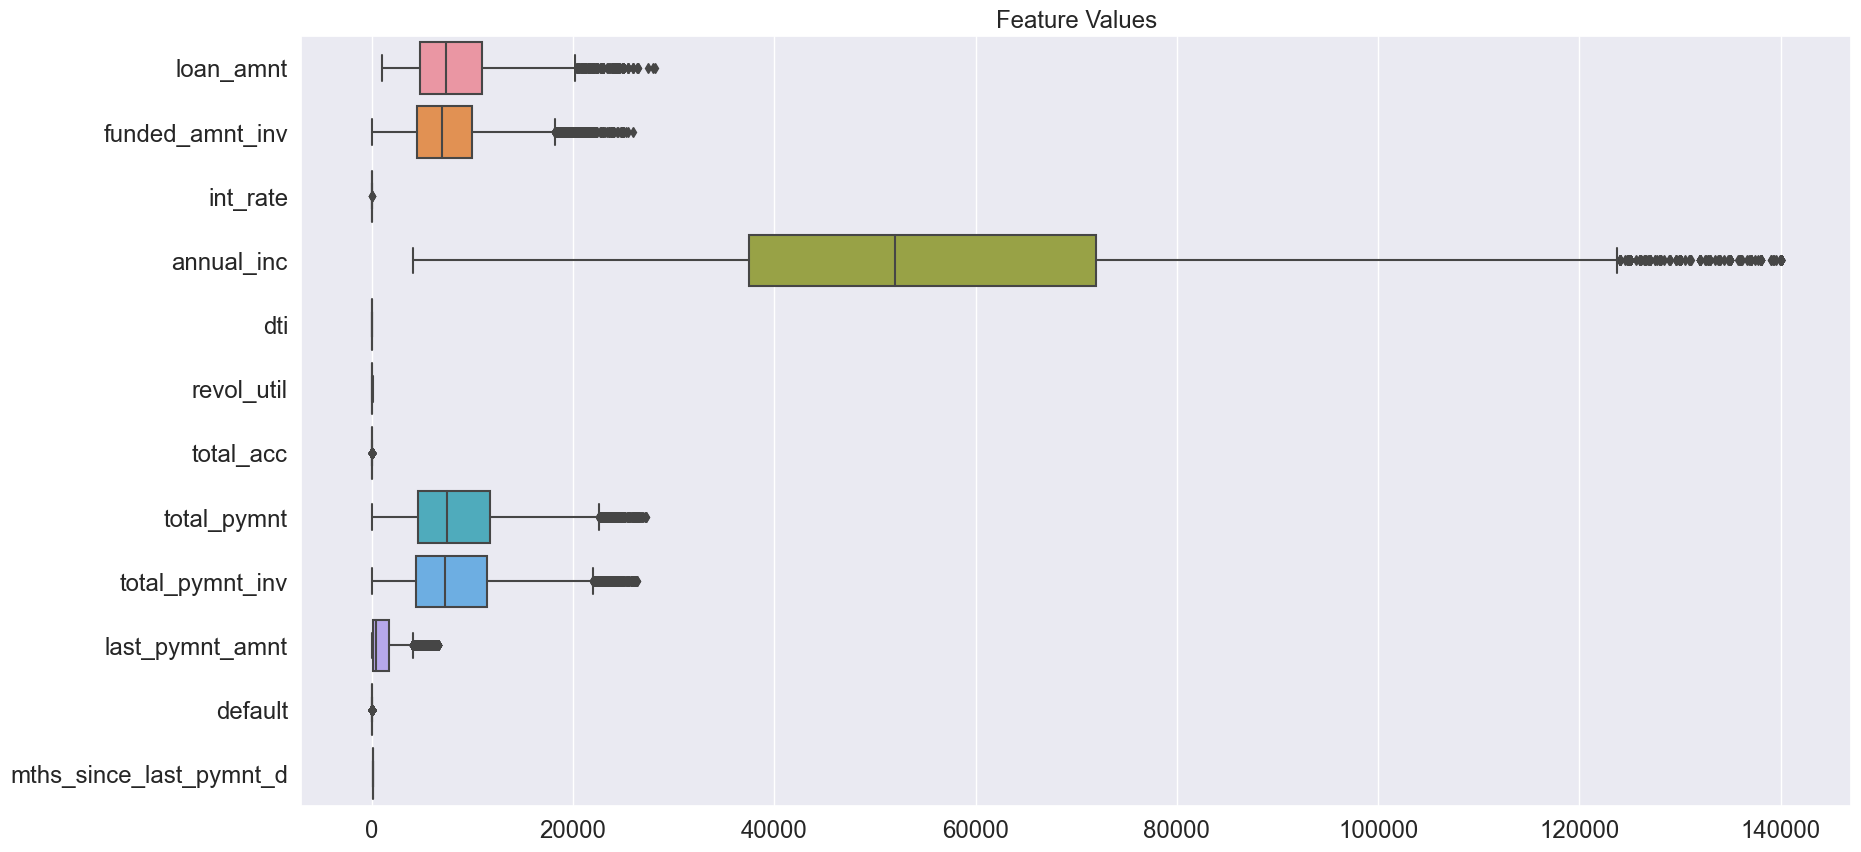

In [25]:
def visualize_feature_scaling(df):
    numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

    if len(numerical_columns) == 0:
        print("No numerical features found in the DataFrame.")

    # Create a box plot to visualize feature scaling
    plt.figure()
    sns.boxplot(data=df[numerical_columns], orient='h')
    plt.title('Feature Values')
    plt.xlabel(None)
    plt.ylabel(None)

    plt.show()


num_features = get_numerical_columns(df_train)
visualize_feature_scaling(df_train[num_features])

In [26]:
import numpy as np

def add_log_transform_remove_zeros(df, variables, small_constant=1e-10):
    df = df.copy()  # to avoid modifying the original dataframe

    # Removing rows where any of the variables are zero
    for variable in variables:
        df = df[df[variable] != 0]

    # Adding log-transformed variables
    for variable in variables:
        new_variable_name = f"log_{variable}"
        df[new_variable_name] = np.log(df[variable] + small_constant)
        
    return df

# Scale features
features_to_scale = ['loan_amnt', 'funded_amnt_inv', 'annual_inc', 'total_pymnt', 'last_pymnt_amnt', 'total_pymnt_inv']
df_train = add_log_transform_remove_zeros(df_train, features_to_scale)

# Remove original features to scale
df_train.drop(columns=features_to_scale, inplace=True)

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-X_uvMH0R-py3.10/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


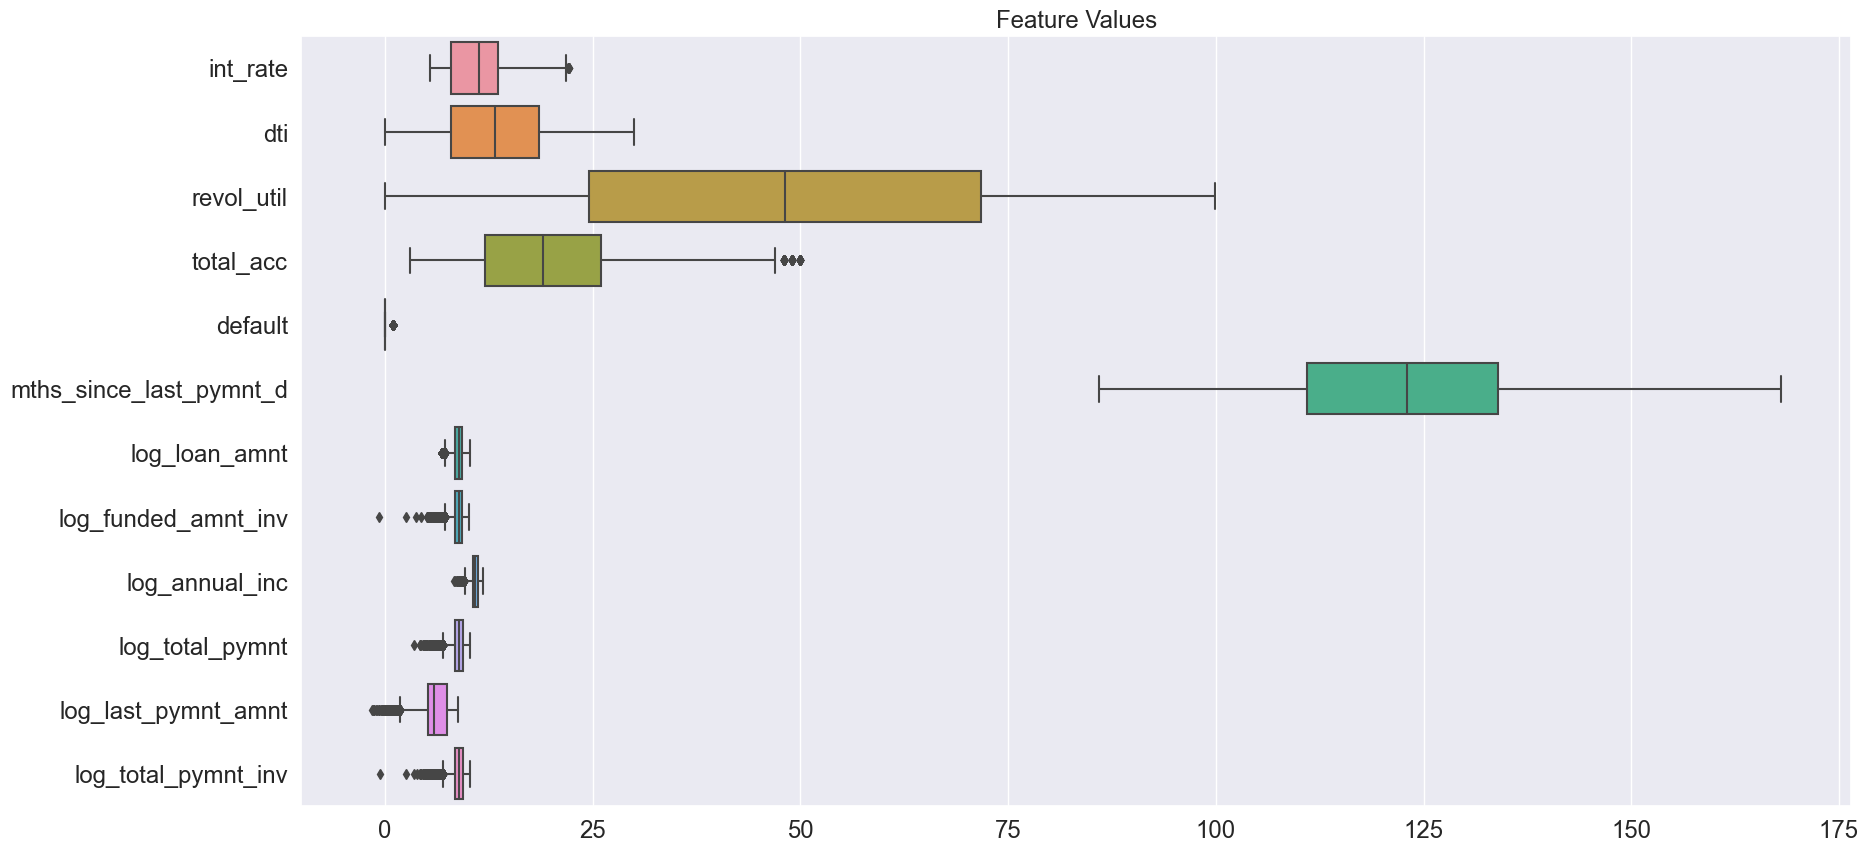

In [27]:
num_features = get_numerical_columns(df_train)
visualize_feature_scaling(df_train[num_features])

### WoE and IV of Categorical Features

In [28]:
from validmind.tests.data_validation.WOEIVTable import WOEIVTable

# Update vm dataset and test context
vm_df_train = vm.init_dataset(dataset=df_train, 
                              target_column=target_column)
test_context = TestContext(dataset=vm_df_train)

# Configure test parameters
features = ['grade', 'purpose', 'verification_status', 'home_ownership']
params = {
    "features": features,
    "order_by": ["Feature", "IV"]
}

# Run test
metric = WOEIVTable(test_context, params=params)
metric.run()
metric.result.show()

2023-06-28 13:50:47,053 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:47,054 - INFO - dataset - Inferring dataset types...


In [29]:
from validmind.tests.data_validation.WOEIVPlots import WOEIVPlots

# Update vm dataset and test context
vm_df_train = vm.init_dataset(dataset=df_train, 
                              target_column=target_column)
test_context = TestContext(dataset=vm_df_train)

# Configure test parameters
features = ['grade', 'purpose', 'verification_status', 'home_ownership']
params = {
    "features": features,
    "label_rotation": 90
}

# Run test
metric = WOEIVPlots(test_context, params=params)
metric.run()
metric.result.show()

2023-06-28 13:50:47,286 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:47,287 - INFO - dataset - Inferring dataset types...


### WoE and IV of Numerical Features

In [30]:
def bin_numerical_variables(df, columns_list, bins=5, labels=None):
    """
    Bin the specified numerical columns into categories.
    
    Parameters:
    df (pandas.DataFrame): DataFrame to be processed.
    columns_list (list): List of column names to be processed.
    bins (int or sequence, optional): Number of bins to create, or a sequence representing the bins.
    labels (list, optional): Labels for the bins. Must be the same length as the resulting bins.

    Returns:
    pandas.DataFrame: A DataFrame with the new binned columns.
    """
    df_copy = df.copy()
    
    for column in columns_list:
        if pd.api.types.is_numeric_dtype(df[column]):
            # Convert the bin intervals to strings
            df_copy[column+'_bin'] = pd.cut(df[column], bins=bins, labels=labels).astype(str)
        else:
            raise ValueError(f"Column {column} is not numerical.")
        
    return df_copy

In [31]:
# Bin numerical features for WoE and IV analysis
#numerical_features_to_bin = get_numerical_columns(df_train)
#df_train = bin_numerical_variables(df_train, numerical_features_to_bin)

In [32]:
#categorical_columns = [f+'_bin' for f in numerical_features_to_bin]
#woe_iv_df_numerical = calculate_woe_iv(df_train, target_column, categorical_columns)
#display(woe_iv_df_numerical)

### Encoding of Categorical Features

In [33]:
def add_dummy_variables(df, columns_list):
    """
    Generate dummy variables for specified columns in the DataFrame,
    concatenate them with the original DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame to be processed.
    columns_list (list): List of column names to be processed.

    Returns:
    df (pandas.DataFrame): DataFrame after processing.
    """
    for column in columns_list:
        dummies = pd.get_dummies(df[column], prefix=column + "_", drop_first=False)
        df.drop(columns=[column], inplace=True)
        df = pd.concat([df, dummies], axis=1)
    return df

categorical_columns = ['purpose', 'grade', 'verification_status', 'home_ownership']
df_train = add_dummy_variables(df_train, categorical_columns)

### Update Test Data

In [34]:
# Data cleaning
clean_date_columns(df_test, ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d'])
clean_rate_columns(df_test, 'int_rate')
clean_rate_columns(df_test, 'revol_util')
clean_emp_length_column(df_test, 'emp_length')
clean_term_column(df_test, 'term')
clean_inq_last_6mths(df_test, 'inq_last_6mths')

# Drop NaN values 
df_test.dropna(subset=['mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d'], inplace=True)

# Drop features
df_test.drop(columns=drop_categorical_features + drop_numerical_features, inplace=True)

# Scale features
features_to_scale = ['loan_amnt', 'funded_amnt_inv', 'annual_inc', 'total_pymnt', 'last_pymnt_amnt']
df_test = add_log_transform_remove_zeros(df_test, features_to_scale)

# Remove original features to scale
df_test.drop(columns=features_to_scale, inplace=True)

# Dummy features 
categorical_columns = ['purpose', 'grade', 'verification_status', 'home_ownership']
df_test = add_dummy_variables(df_test, categorical_columns)

# Reindex df_train and df_test
df_test = df_test.reindex(labels=df_train.columns, axis=1, fill_value=0)

## Model Training 

Separating Features and Target Variables for Training and Test Sets.

In [35]:
X_train = df_train.drop(target_column, axis=1)  
y_train = df_train[target_column]  

X_test = df_test.drop(target_column, axis=1)  
y_test = df_test[target_column]

In [36]:
vm_df = vm.init_dataset(dataset=df_train,
                        target_column=target_column)
test_context = TestContext(dataset=vm_df)

params = {"features": None, 
          "declutter": True,
          "fontsize": 13}

metric = HeatmapFeatureCorrelations(test_context, params)
metric.run()
metric.result.show()

2023-06-28 13:50:49,187 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:49,188 - INFO - dataset - Inferring dataset types...


In [37]:
vm_df = vm.init_dataset(dataset=df_train,
                        target_column=target_column)
test_context = TestContext(dataset=vm_df)

features = get_numerical_columns(df_train)
params = {"declutter": False,
          "features": None,
          "fontsize": 13}

metric = FeatureTargetCorrelationPlot(test_context, params)
metric.run()
metric.result.show()

2023-06-28 13:50:49,926 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:49,926 - INFO - dataset - Inferring dataset types...


In [38]:
vm_df = vm.init_dataset(dataset=X_train)
test_context = TestContext(dataset=vm_df)

metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

2023-06-28 13:50:50,672 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:50,672 - INFO - dataset - Inferring dataset types...


### Feature Statistical Significance 

Train a GLM Logistic Regression Model.

In [39]:
import statsmodels.api as sm

# Add constant to X_train for intercept term
#X_train = sm.add_constant(X_train)

# Define the model
model = sm.GLM(y_train, X_train, family=sm.families.Binomial())

# Fit the model
model_fit = model.fit()

# Print out the statistics
print(model_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                20276
Model:                            GLM   Df Residuals:                    20240
Model Family:                Binomial   Df Model:                           35
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -950.24
Date:                Wed, 28 Jun 2023   Deviance:                       1900.5
Time:                        13:50:52   Pearson chi2:                 3.31e+05
No. Iterations:                    11   Pseudo R-squ. (CS):             0.5328
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


**Run VM Test**

In [40]:
from validmind.tests.model_validation.statsmodels.RegressionModelsCoeffs import RegressionModelsCoeffs

# Create VM test and train datasets
vm_train_ds = vm.init_dataset(dataset=df_train,
                        target_column=target_column)
vm_test_ds = vm.init_dataset(dataset=df_test,
                        target_column=target_column)

# Create VM model
vm_model = vm.init_model(
    model = model_fit, 
    train_ds=vm_train_ds, 
    test_ds=vm_test_ds)
list_of_models = [vm_model]
test_context = TestContext(models=list_of_models)

# Run test
metric = RegressionModelsCoeffs(test_context)
metric.run()
metric.result.show()

2023-06-28 13:50:52,119 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:52,125 - INFO - dataset - Inferring dataset types...
2023-06-28 13:50:52,533 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-28 13:50:52,533 - INFO - dataset - Inferring dataset types...


**Run VM Test**

In [41]:
from validmind.tests.model_validation.statsmodels.RegressionModelPValuePlot import RegressionModelPValuePlot

params = {"p_threshold": 0.1,
          "fontsize": 12}

metric = RegressionModelPValuePlot(test_context, params)
metric.run()
metric.result.show()

### Feature Importance

Build a Decision Tree model to calculate feature importance on all preliminary features.

In [42]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
tree_model = DecisionTreeClassifier(random_state=0)

# Fit the model
tree_model_fit = tree_model.fit(X_train, y_train)

In [47]:
from validmind.tests.model_validation.sklearn.PermutationFeatureImportance import PermutationFeatureImportance

# Create VM model
vm_model = vm.init_model(
    model = tree_model_fit, 
    train_ds=vm_train_ds, 
    test_ds=vm_test_ds)

test_context = TestContext(model=vm_model)

params = {"fontsize": None}

metric = PermutationFeatureImportance(test_context, params)
metric.run()
metric.result.show()

### Scorecard Development

### Map Model Fit Coefficients to Scores

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def calculate_scores(model, scaling_factor=None, base_points=None):
    # Set default values if not provided
    if scaling_factor is None:
        scaling_factor = 20 / np.log(2)
    if base_points is None:
        base_points = 500

    # Get the coefficients from the model
    coefficients = model.params.values
    
    # Get the feature names from the model
    selected_features = model.params.index

    # Calculate odds ratios
    odds_ratios = np.exp(coefficients).reshape(-1)
    
    # Calculate the scores for each coefficient
    scores = scaling_factor * np.log(odds_ratios)
    scores = base_points - scores

    # Create a DataFrame to store feature names and their corresponding scores
    feature_scores = pd.DataFrame({'Feature': selected_features, 'Score': scores})

    # Sort the DataFrame in descending order of scores
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)

    return feature_scores


scores = calculate_scores(model_fit)
display(scores)

### Distribution of Scores 

# Appendix

## Step 8: Univariate Analysis

### Histograms of Numerical Features

**Update VM Dataset and Run Test**

In [ ]:
from validmind.tests.data_validation.TabularNumericalHistograms import TabularNumericalHistograms

vm_df_train = vm.init_dataset(dataset=df_train)
test_context = TestContext(dataset=vm_df_train)

metric = TabularNumericalHistograms(test_context)
metric.run()
metric.result.show()

In [ ]:
# If 'df' is your DataFrame and 'column_name' is the name of the column
unique_values = df['inq_last_6mths'].unique()
print(unique_values)


### High Cardinality of Categorical Features

**Run Test**

In [ ]:
from validmind.tests.data_validation.HighCardinality import HighCardinality
metric = HighCardinality(test_context)
metric.run()
metric.result.show()

### Bar Plots of Categorical Features

**Run Test**

In [ ]:
from validmind.tests.data_validation.TabularCategoricalBarPlots import TabularCategoricalBarPlots
metric = TabularCategoricalBarPlots(test_context)
metric.run()
metric.result.show()

### Default Ratios by Categorical Feature

**Run Test**

In [ ]:
from validmind.tests.data_validation.DefaultRatioBarPlots import DefaultRatioBarPlots

# Configure the metric
params = {
    "default_column": target_column,
    "columns": None
}

metric = DefaultRatioBarPlots(test_context, params=params)
metric.run()
metric.result.show()

## Step 9: Multivariate Analysis

### Bivariate Bar Plots of Default Ratios

**Update VM Dataset and Run Test**

In [ ]:
from validmind.tests.data_validation.BivariateFeaturesBarPlots import BivariateFeaturesBarPlots

# Pass target column to validmind dataset
vm_df_train = vm.init_dataset(dataset=df_train, 
                              target_column=target_column)
test_context = TestContext(dataset=vm_df_train)

# Configure the metric
features_pairs = {'home_ownership': 'grade', 
                  'purpose': 'grade',
                  'grade': 'verification_status'}

params = {
    "features_pairs": features_pairs,
}

metric = BivariateFeaturesBarPlots(test_context, params=params)
metric.run()

### Scatter Plots by Default Status

**Run Test**

In [ ]:
from validmind.tests.data_validation.BivariateScatterPlots import BivariateScatterPlots

features_pairs = {'int_rate': 'annual_inc', 
                  'funded_amnt_inv': 'dti', 
                  'annual_inc': 'funded_amnt_inv',
                  'loan_amnt': 'int_rate',
                  'int_rate': 'annual_inc',
                  'earliest_cr_line': 'int_rate'}

params = {
    "features_pairs": features_pairs,
    "target_filter": None
}

metric = BivariateScatterPlots(test_context, params=params)
metric.run()

### Bivariate Histograms

**Run Test**

In [ ]:
from validmind.tests.data_validation.BivariateHistograms import BivariateHistograms

features_pairs = {'int_rate': 'annual_inc', 
                  'funded_amnt_inv': 'dti', 
                  'annual_inc': 'funded_amnt_inv',
                  'loan_amnt': 'int_rate',
                  'int_rate': 'annual_inc',
                  'earliest_cr_line': 'int_rate'}

params = {
    "features_pairs": features_pairs,
    "target_filter": None
}

metric = BivariateHistograms(test_context, params=params)
metric.run()

**Run Test**

In [ ]:
from validmind.tests.data_validation.PearsonCorrelationMatrix import PearsonCorrelationMatrix

metric = PearsonCorrelationMatrix(test_context)
metric.run()
metric.result.show()

## Step 10: Feature Engineering 

### Add Dummy Catergorical Variables

In [ ]:
def add_dummy_variables(df, columns_list):
    """
    Generate dummy variables for specified columns in the DataFrame,
    concatenate them with the original DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame to be processed.
    columns_list (list): List of column names to be processed.
    """
    for column in columns_list:
        dummies = pd.get_dummies(df[column], prefix=column + ":", drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df


In [ ]:
# df_train = add_dummy_variables(df_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])
# df_test = add_dummy_variables(df_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])

In [ ]:
# Adjust the X_test DataFrame to match the column structure of the X_train DataFrame
# df_test = df_test.reindex(labels=df_train.columns, axis=1, fill_value=0)

### Weight of Evidence (WoE) Binning

From a modelling perspective, the **WoE** allows us to transform raw variables into a format which provides a more robust base for statistical analysis. Specifically, the WoE measures the predictive power of an individual class of a categorical variable, distinguishing between 'good' (non-defaulters) and 'bad' (defaulters) risks. This is accomplished by comparing the distribution of 'good' and 'bad' risks within a specific category to the overall 'good'/'bad' distribution. If the 'good'/'bad' ratio of a particular category is significantly divergent from the overall ratio, it suggests that category is a strong predictor of credit risk.

**Information Value (IV)**, on the other hand, is a fundamental metric we use to quantify the predictive power of each input variable in our scorecards. The IV is calculated by taking the sum of the differences between the WoE of each category and the overall WoE, multiplied by the WoE of that category. In other words, IV measures the total amount of 'information' or predictive power a variable brings to the model. For example, variables with an IV between 0.1 and 0.3 provide a weak predictive power, those between 0.3 and 0.5 a medium predictive power, and those with an IV greater than 0.5 have strong predictive power. Therefore, we utilize the IV to prioritize variables for inclusion in the model and to ensure the model's stability and accuracy.

#### WoE and IV for Categorical Variables

In [ ]:
#categorical_woe_iv_df = calculate_woe_iv(df_train, target_column, categorical_features)
#display(categorical_woe_iv_df)

**Update VM Dataset and Run Test**

In [ ]:
from validmind.tests.data_validation.WOEIVPlots import WoEandIVPlots

# Update vm dataset and test context
vm_df_train = vm.init_dataset(dataset=df_train, 
                              target_column=target_column)
test_context = TestContext(dataset=vm_df_train)

# Configure test parameters
params = {
    "features": categorical_features,
    "label_rotation": 90
}

# Run test
metric = WoEandIVPlots(test_context, params=params)
metric.run()
metric.result.show()

#### WoE and IV for Numerical Variables

Binning numerical features for WOE and IV calculations. 

In [ ]:
def bin_numerical_variables(df, columns_list, bins=5, labels=None):
    """
    Bin the specified numerical columns into categories.
    
    Parameters:
    df (pandas.DataFrame): DataFrame to be processed.
    columns_list (list): List of column names to be processed.
    bins (int or sequence, optional): Number of bins to create, or a sequence representing the bins.
    labels (list, optional): Labels for the bins. Must be the same length as the resulting bins.

    Returns:
    pandas.DataFrame: A DataFrame with the new binned columns.
    """
    df_copy = df.copy()
    
    for column in columns_list:
        if pd.api.types.is_numeric_dtype(df[column]):
            # Convert the bin intervals to strings
            df_copy[column+'_bin'] = pd.cut(df[column], bins=bins, labels=labels).astype(str)
        else:
            raise ValueError(f"Column {column} is not numerical.")
        
    return df_copy


In [ ]:
numerical_features_to_bin = ['loan_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'total_acc']
df_train = bin_numerical_variables(df_train, numerical_features_to_bin)

# Create a list of binned features
binned_numerical_features = [f+'_bin' for f in numerical_features]

# Calculate WoE and IV for the binned features
woe_iv_df_numerical = calculate_woe_iv(df_train, target_column, binned_numerical_features)

# Display the resulting DataFrame
# display(woe_iv_df_numerical)

**Update VM Dataset and Run Test**

In [ ]:
# Update vm dataset and test context
vm_df_train = vm.init_dataset(dataset=df_train, 
                              target_column=target_column)
test_context = TestContext(dataset=vm_df_train)

# Configure test parameters
params = {
    "features": binned_numerical_features,
    "label_rotation": 90
}

# Run test
metric = WoEandIVPlots(test_context, params=params)
metric.run()
metric.result.show()

### Create Dummy Features from Binned Numerical Columns

In [ ]:
#binned_numerical_columns = ['loan_amnt_bin', 'funded_amnt_inv_bin', 'int_rate_bin', 'installment_bin', 'emp_length_bin',
#                                'annual_inc_bin', 'dti_bin', 'inq_last_6mths_bin', 'open_acc_bin', 'total_acc_bin']
#df_train = add_dummy_variables(df_train, binned_numerical_columns)
#df_train.drop(columns=binned_numerical_columns, inplace=True)                          

### Create Binned Datetime Features

Create new numerical features from datetime columns for WoE and IV analysis.

In [ ]:
# Let's assume today's date to calculate years since.
today = pd.to_datetime('today')

def add_years_since_issue(df, issue_date_column='issue_d'):
    """
    Calculates the number of years since the loan was issued.
    """
    # Calculate the difference in years
    df['years_since_issue'] = (today - df[issue_date_column]).dt.days / 365.25

def add_credit_history_length(df, earliest_credit_column='earliest_cr_line'):
    """
    Calculates the length of the borrower's credit history in years.
    """
    # Calculate the credit history length
    df['credit_history_length'] = (today - df[earliest_credit_column]).dt.days / 365.25

add_years_since_issue(df_train)
add_credit_history_length(df_train)

Add binned numerical features `years_since_issue_bin` and `credit_history_length_bin` to `df_train` dataset. 

In [ ]:
datetime_features = ['years_since_issue', 'credit_history_length']
df_train = bin_numerical_variables(df_train, datetime_features)

# Create a list of binned features
binned_datetime_features = [f+'_bin' for f in datetime_features]

**Update VM Dataset and Run Test**

In [ ]:
# Update vm dataset and test context
vm_df_train = vm.init_dataset(dataset=df_train, 
                              target_column=target_column)
test_context = TestContext(dataset=vm_df_train)

# Configure test parameters
params = {
    "features": binned_datetime_features,
    "label_rotation": 90
}

# Run test
metric = WoEandIVPlots(test_context, params=params)
metric.run()
metric.result.show()



Add dummy features for datetime variables, keep the original datetime variables, and drop binned features. 

In [ ]:
# df_train = add_dummy_variables(df_train, binned_datetime_features)
df_train.drop(columns=binned_datetime_features, inplace=True)
df_train.drop(columns=['issue_d', 'earliest_cr_line'])

#### Histograms of Correlations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_and_plot_correlations(df, num_ranges):
    # Compute Pearson correlations
    correlations = df.corr(method='pearson')

    # Flatten the correlation matrix and remove self correlations
    corr_values = correlations.values.flatten()
    corr_values = corr_values[~np.isnan(corr_values)]
    corr_values = corr_values[corr_values != 1]

    # Define the ranges for histograms
    range_values = np.linspace(-1, 1, num_ranges + 1)

    # Calculate the number of rows and columns for subplots
    num_rows = (num_ranges + 1) // 2
    num_cols = 2

    # Create the subplots
    fig, axs = plt.subplots(num_rows, num_cols, squeeze=False)

    # Plot histograms for each range
    for i, ax in enumerate(axs.flat):
        if i < num_ranges:
            lower_bound = range_values[i]
            upper_bound = range_values[i + 1]

            ax.hist(corr_values[(corr_values >= lower_bound) & (corr_values < upper_bound)], bins=50)
            ax.set_xlabel('Correlation')
            ax.set_ylabel('Frequency')
            ax.set_title(f'Correlations {lower_bound} to {upper_bound}')
            ax.tick_params(axis='x', rotation=90)
        else:
            ax.axis('off')

    # Remove any empty subplots if the number of ranges is odd
    if num_ranges % 2 != 0:
        axs[-1, -1].axis('off')

    plt.tight_layout()
    plt.show()



compute_and_plot_correlations(df_train, 1)

### Correlation of Features with the Target Variable

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_and_plot_correlations_with_target(df, target_col, num_ranges):
    # Compute Pearson correlations with the target variable
    correlations = df.corr()[target_col].drop(target_col)
    
    # Remove missing correlations
    correlations = correlations.dropna()

    # Define the ranges for histograms
    range_values = np.linspace(-1, 1, num_ranges + 1)

    # Calculate the number of rows and columns for subplots
    num_rows = (num_ranges + 1) // 2
    num_cols = 2

    # Create the subplots
    fig, axs = plt.subplots(num_rows, num_cols, squeeze=False)

    # Plot histograms for each range
    for i, ax in enumerate(axs.flat):
        if i < num_ranges:
            lower_bound = range_values[i]
            upper_bound = range_values[i + 1]

            ax.hist(correlations[(correlations >= lower_bound) & (correlations < upper_bound)], bins=50)
            ax.set_xlabel('Correlation')
            ax.set_ylabel('Frequency')
            ax.set_title(f'Correlations {lower_bound} to {upper_bound}')
            ax.tick_params(axis='x', rotation=90)
        else:
            ax.axis('off')

    # Remove any empty subplots if the number of ranges is odd
    if num_ranges % 2 != 0:
        axs[-1, -1].axis('off')

    plt.tight_layout()
    plt.show()


corr_with_target = compute_and_plot_correlations_with_target(df_train, 'default', 1)

In [ ]:
from validmind.vm_models.test_context import TestContext
from validmind.tests.data_validation.TabularDescriptionTables import TabularDescriptionTables

vm_df = vm.init_dataset(dataset=df_train)
test_context = TestContext(dataset=vm_df)

metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

## Step 11: Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# First, we define the preprocessing steps
numeric_features = ['pub_rec', 'revol_util', 'funded_amnt_inv', 'int_rate', 'dti', 'annual_inc', 'loan_amnt', 'earliest_cr_line']
categorical_features = ['term', 'grade', 'purpose', 'annual_inc_range', 'loan_amnt_range']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))])



# Train the model
clf.fit(X_train, y_train)

# We can now evaluate on the test set
print("model score: %.3f" % clf.score(X_test, y_test))


In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import pandas as pd

# First, we define the preprocessing steps
numeric_features = ['pub_rec', 'revol_util', 'funded_amnt_inv', 'int_rate', 'dti', 'annual_inc', 'loan_amnt', 'earliest_cr_line']
categorical_features = ['term', 'grade', 'purpose', 'annual_inc_range', 'loan_amnt_range', 'installment']  # Added 'installment'

# Handle categorical features
df_encoded = pd.get_dummies(df_multivariate, columns=categorical_features)

# Split the data
X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Add a constant to the independent values
X_train = sm.add_constant(X_train)

# Define the model
glm_model_fit = sm.GLM(y_train, X_train, family=sm.families.Binomial())

# Fit the model
results = glm_model_fit.fit()

# Print the summary
print(results.summary())

# Evaluate on the test set
X_test = sm.add_constant(X_test)  # Adding a constant to the test data
y_pred = results.predict(X_test)

# You can then further analyze y_pred to measure model performance on the test set.

Scale variable X. 

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import scale

# Scale your variables
X_scaled = scale(X)

# Add a constant to the independent values
X_scaled = sm.add_constant(X_scaled)

# Define the model
model = sm.GLM(y, X_scaled, family=sm.families.Binomial())

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())


#### ValidMind Models 

In [ ]:
# Initialize training and testing datasets for model A
vm_train_ds = vm.init_dataset(dataset=X_train, type="generic", target_column='loan_status')
vm_test_ds = vm.init_dataset(dataset=X_test, type="generic", target_column='loan_status')

# Initialize model A
vm_model_A = vm.init_model(
    model = glm_model_fit, 
    train_ds=vm_train_ds, 
    test_ds=vm_test_ds)